In [196]:
import csv
import numpy

def readModelData(path):
    models = []
    tempHistorical = {}

    with open(path, 'r') as csvfile:
        data = csv.reader(csvfile, delimiter=',')

        line = 1

        for row in data:
            # on the header line
            if line == 1:
                # break apart the date and store it
                tempHistorical['Year'] = []
                tempHistorical['Month'] = []
                tempHistorical['Day'] = []
                
                # loop over all model header cols
                for i in range(1, len(row)):
                    row[i] = row[i].replace('"', '').replace("'", '').strip()
                    # if it's not a blank col, store it in the model list and as a new key in the dict
                    if len(row[i]) > 0:
                        models.append(row[i])
                        tempHistorical[row[i]] = []
            else:
                # if not on first line, grab data for time
                timeParts = row[0].replace("'", '').strip().split('/')
                if len(timeParts) == 3:
                    tempHistorical['Month'].append(float(timeParts[0]))
                    tempHistorical['Year'].append(float(timeParts[2]))
                
                    # and for each model
                    for i in range(2, len(models)+2):
                        value = None
                        # try to convert to float, keep as None if it fails
                        try:
                            value = float(row[i].replace("'", '').replace('"', '').strip())
                        except:
                            pass
                        tempHistorical[models[i-2]].append(value)
            line += 1


    # convert all cols to numpy arrays
    for key in list(tempHistorical.keys()):
        tempHistorical[key] = numpy.array(tempHistorical[key])
        
        # convert any None values into numpy.nan
        ind = numpy.where(tempHistorical[key] == None)
        tempHistorical[key][ind] = numpy.nan
    
    return [tempHistorical, models]


In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot annual mean temp across all historical models

[tempHistorical, models] = readModelData('data/r1-temp-rcp45.csv')
tempHistorical[models[-1]][-1]

19.034216000000001

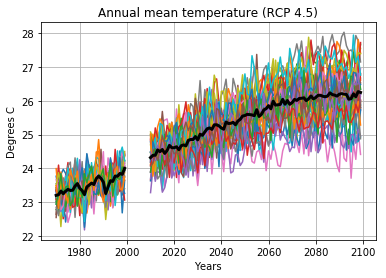

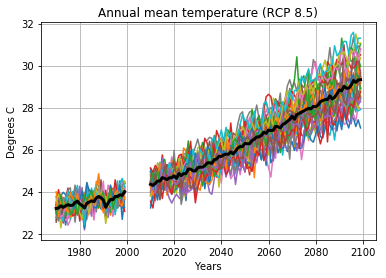

In [202]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot annual mean temp across all historical models

def plotAnnualMean(data, title):
    # get all unique years
    years = numpy.unique(data['Year'])

    annMean = []

    # for all models
    for model in models:
        if model == 'Actual': continue
            
        curAnnMean = []
        for year in years:
            # find indices for current year
            ind = numpy.where(data['Year'] == year)

            # take mean across all months if possible, otherwise set to nan
            try:
                curAnnMean.append(numpy.nanmean(data[model][ind]))
            except:
                curAnnMean.append(numpy.nan)
        
        # store and plot current year/model's list of annual means
        annMean.append(curAnnMean)
        plt.plot(years, curAnnMean)
    
    # convert to numpy array and take multi-model mean
    annMean = numpy.array(annMean)
    multiModelMean = numpy.nanmean(annMean, axis=0)

    plt.plot(years, multiModelMean, 'k-', linewidth=3)
    plt.xlabel('Years')
    plt.ylabel('Degrees C')
    plt.title(title)


[tempHistorical, models] = readModelData('data/r1-temp-historical.csv')
[tempRcp45, models] = readModelData('data/r1-temp-rcp45.csv')
[tempRcp85, models] = readModelData('data/r1-temp-rcp85.csv')

# plot historical and RCP 4.5/RCP 8.5
plt.figure(0)
plt.grid()
plotAnnualMean(tempHistorical, 'Annual mean temperature (historical)')
plotAnnualMean(tempRcp45, 'Annual mean temperature (RCP 4.5)')
plt.savefig('temp-rcp45.png', dpi=600)

plt.figure(1)
plt.grid()
plotAnnualMean(tempHistorical, 'Annual mean temperature (historical)')
plotAnnualMean(tempRcp85, 'Annual mean temperature (RCP 8.5)')
plt.savefig('temp-rcp85.png', dpi=600)

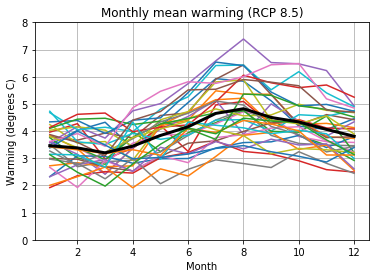

In [200]:
# plot seasonal temp change

import matplotlib.pyplot as plt
%matplotlib inline

[tempHistorical, models] = readModelData('data/r1-temp-historical.csv')
[tempRcp85, models] = readModelData('data/r1-temp-rcp85.csv')

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

futurePeriod = [2060, 2080]

monthlyMeanChg = []

for month in months:
    # get indices of all days in this month
    indHistorical = numpy.where(tempHistorical['Month'] == month)
    # current month in the selected future time period
    indRcp85 = numpy.where((tempRcp85['Month'] == month) & (tempRcp85['Year'] > futurePeriod[0]) & (tempRcp85['Year'] < futurePeriod[1]))
    
    curMonthChg = []
    
    # loop over all models
    for model in models:
        curMonthChg.append(numpy.nanmean(tempRcp85[model][indRcp85]) - numpy.nanmean(tempHistorical[model][indHistorical]))
    
    monthlyMeanChg.append(curMonthChg)


plt.figure(0)
plt.grid()
plt.plot(months, monthlyMeanChg)
plt.plot(months, numpy.nanmean(monthlyMeanChg, axis=1), 'k', linewidth = 3)
plt.xlabel('Month')
plt.ylabel('Warming (degrees C)')
plt.ylim([0, 8])
plt.title('Monthly mean warming (RCP 8.5)')
plt.savefig('monthly-warming.png', dpi=600)

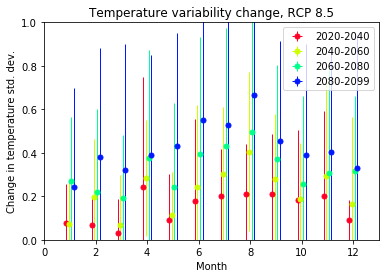

In [186]:
# look at monthly temperature variability

import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

[tempHistorical, models] = readModelData('data/r1-temp-historical.csv')
[tempRcp85, models] = readModelData('data/r1-temp-rcp85.csv')

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

futurePeriods = [[2020, 2040], [2040, 2060], [2060, 2080], [2080, 2099]]
offsets = [-.15, -.05, .05, .15]

colormap = plt.get_cmap('gist_rainbow')
fig = plt.figure(0)
ax = fig.add_subplot(111)
ax.set_prop_cycle(cycler('color', [colormap(1.*i/4) for i in range(4)]) +
                   cycler('lw', [1, 2, 3, 4]))

legendList = []

for month in months:
    for f in range(len(futurePeriods)):
        futurePeriod = futurePeriods[f]
        
        # get indices of all days in this month
        indHistorical = numpy.where(tempHistorical['Month'] == month)
        # current month in the selected future time period
        indRcp85 = numpy.where((tempRcp85['Month'] == month) & (tempRcp85['Year'] > futurePeriod[0]) & (tempRcp85['Year'] < futurePeriod[1]))

        curMonthFuture = []
        curMonthHistorical = []
        curMonthStdChg = []

        # loop over all models
        for model in models:
            # get all years for current month in this model in past and future
            curMonthHistorical.append(tempHistorical[model][indHistorical])
            curMonthFuture.append(tempRcp85[model][indRcp85])

            # take difference in std. across all years in this month in future-past
            curMonthStdChg.append(numpy.std(curMonthFuture) - numpy.std(curMonthHistorical))

        yerr = (max(curMonthStdChg)-min(curMonthStdChg)/2.0)
        p = plt.errorbar(month + offsets[f], numpy.nanmean(curMonthStdChg), yerr, 0, fmt='o', elinewidth=1, markersize=5)
        if month == 1:
            legendList.append(p)

plt.ylim([0, 1])
plt.xlim([0, 13])
plt.xlabel('Month')
plt.ylabel('Change in temperature std. dev.')
plt.title('Temperature variability change, RCP 8.5')
plt.legend(legendList, ['2020-2040', '2040-2060', '2060-2080', '2080-2099'])
plt.savefig('variability-chg.png', dpi=600)
    

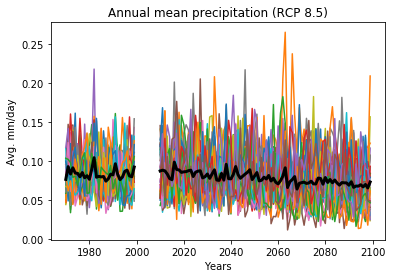

In [207]:
# annual mean precipitaton change

import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

[prHistorical, models] = readModelData('data/r1-pr-historical.csv')
[prRcp85, models] = readModelData('data/r1-pr-rcp85.csv')

plotAnnualMean(prHistorical, 'PR')
plotAnnualMean(prRcp85, 'Annual mean precipitation (RCP 8.5)')
plt.ylabel('Avg. mm/day')

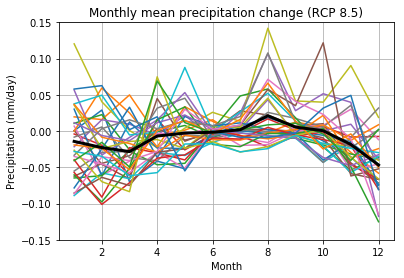

In [213]:
# plot seasonal precip change

import matplotlib.pyplot as plt
%matplotlib inline

[prHistorical, models] = readModelData('data/r1-pr-historical.csv')
[prRcp85, models] = readModelData('data/r1-pr-rcp85.csv')

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

futurePeriod = [2060, 2080]

monthlyMeanChg = []

for month in months:
    # get indices of all days in this month
    indHistorical = numpy.where(prHistorical['Month'] == month)
    # current month in the selected future time period
    indRcp85 = numpy.where((prRcp85['Month'] == month) & (prRcp85['Year'] > futurePeriod[0]) & (prRcp85['Year'] < futurePeriod[1]))
    
    curMonthChg = []
    
    # loop over all models
    for model in models:
        curMonthChg.append(numpy.nanmean(prRcp85[model][indRcp85]) - numpy.nanmean(prHistorical[model][indHistorical]))
    
    monthlyMeanChg.append(curMonthChg)


plt.figure(0)
plt.grid()
plt.plot(months, monthlyMeanChg)
plt.plot(months, numpy.nanmean(monthlyMeanChg, axis=1), 'k', linewidth = 3)
plt.xlabel('Month')
plt.ylabel('Precipitation (mm/day)')
plt.ylim([-0.15, 0.15])
plt.title('Monthly mean precipitation change (RCP 8.5)')
plt.savefig('monthly-pr-chg.png', dpi=600)

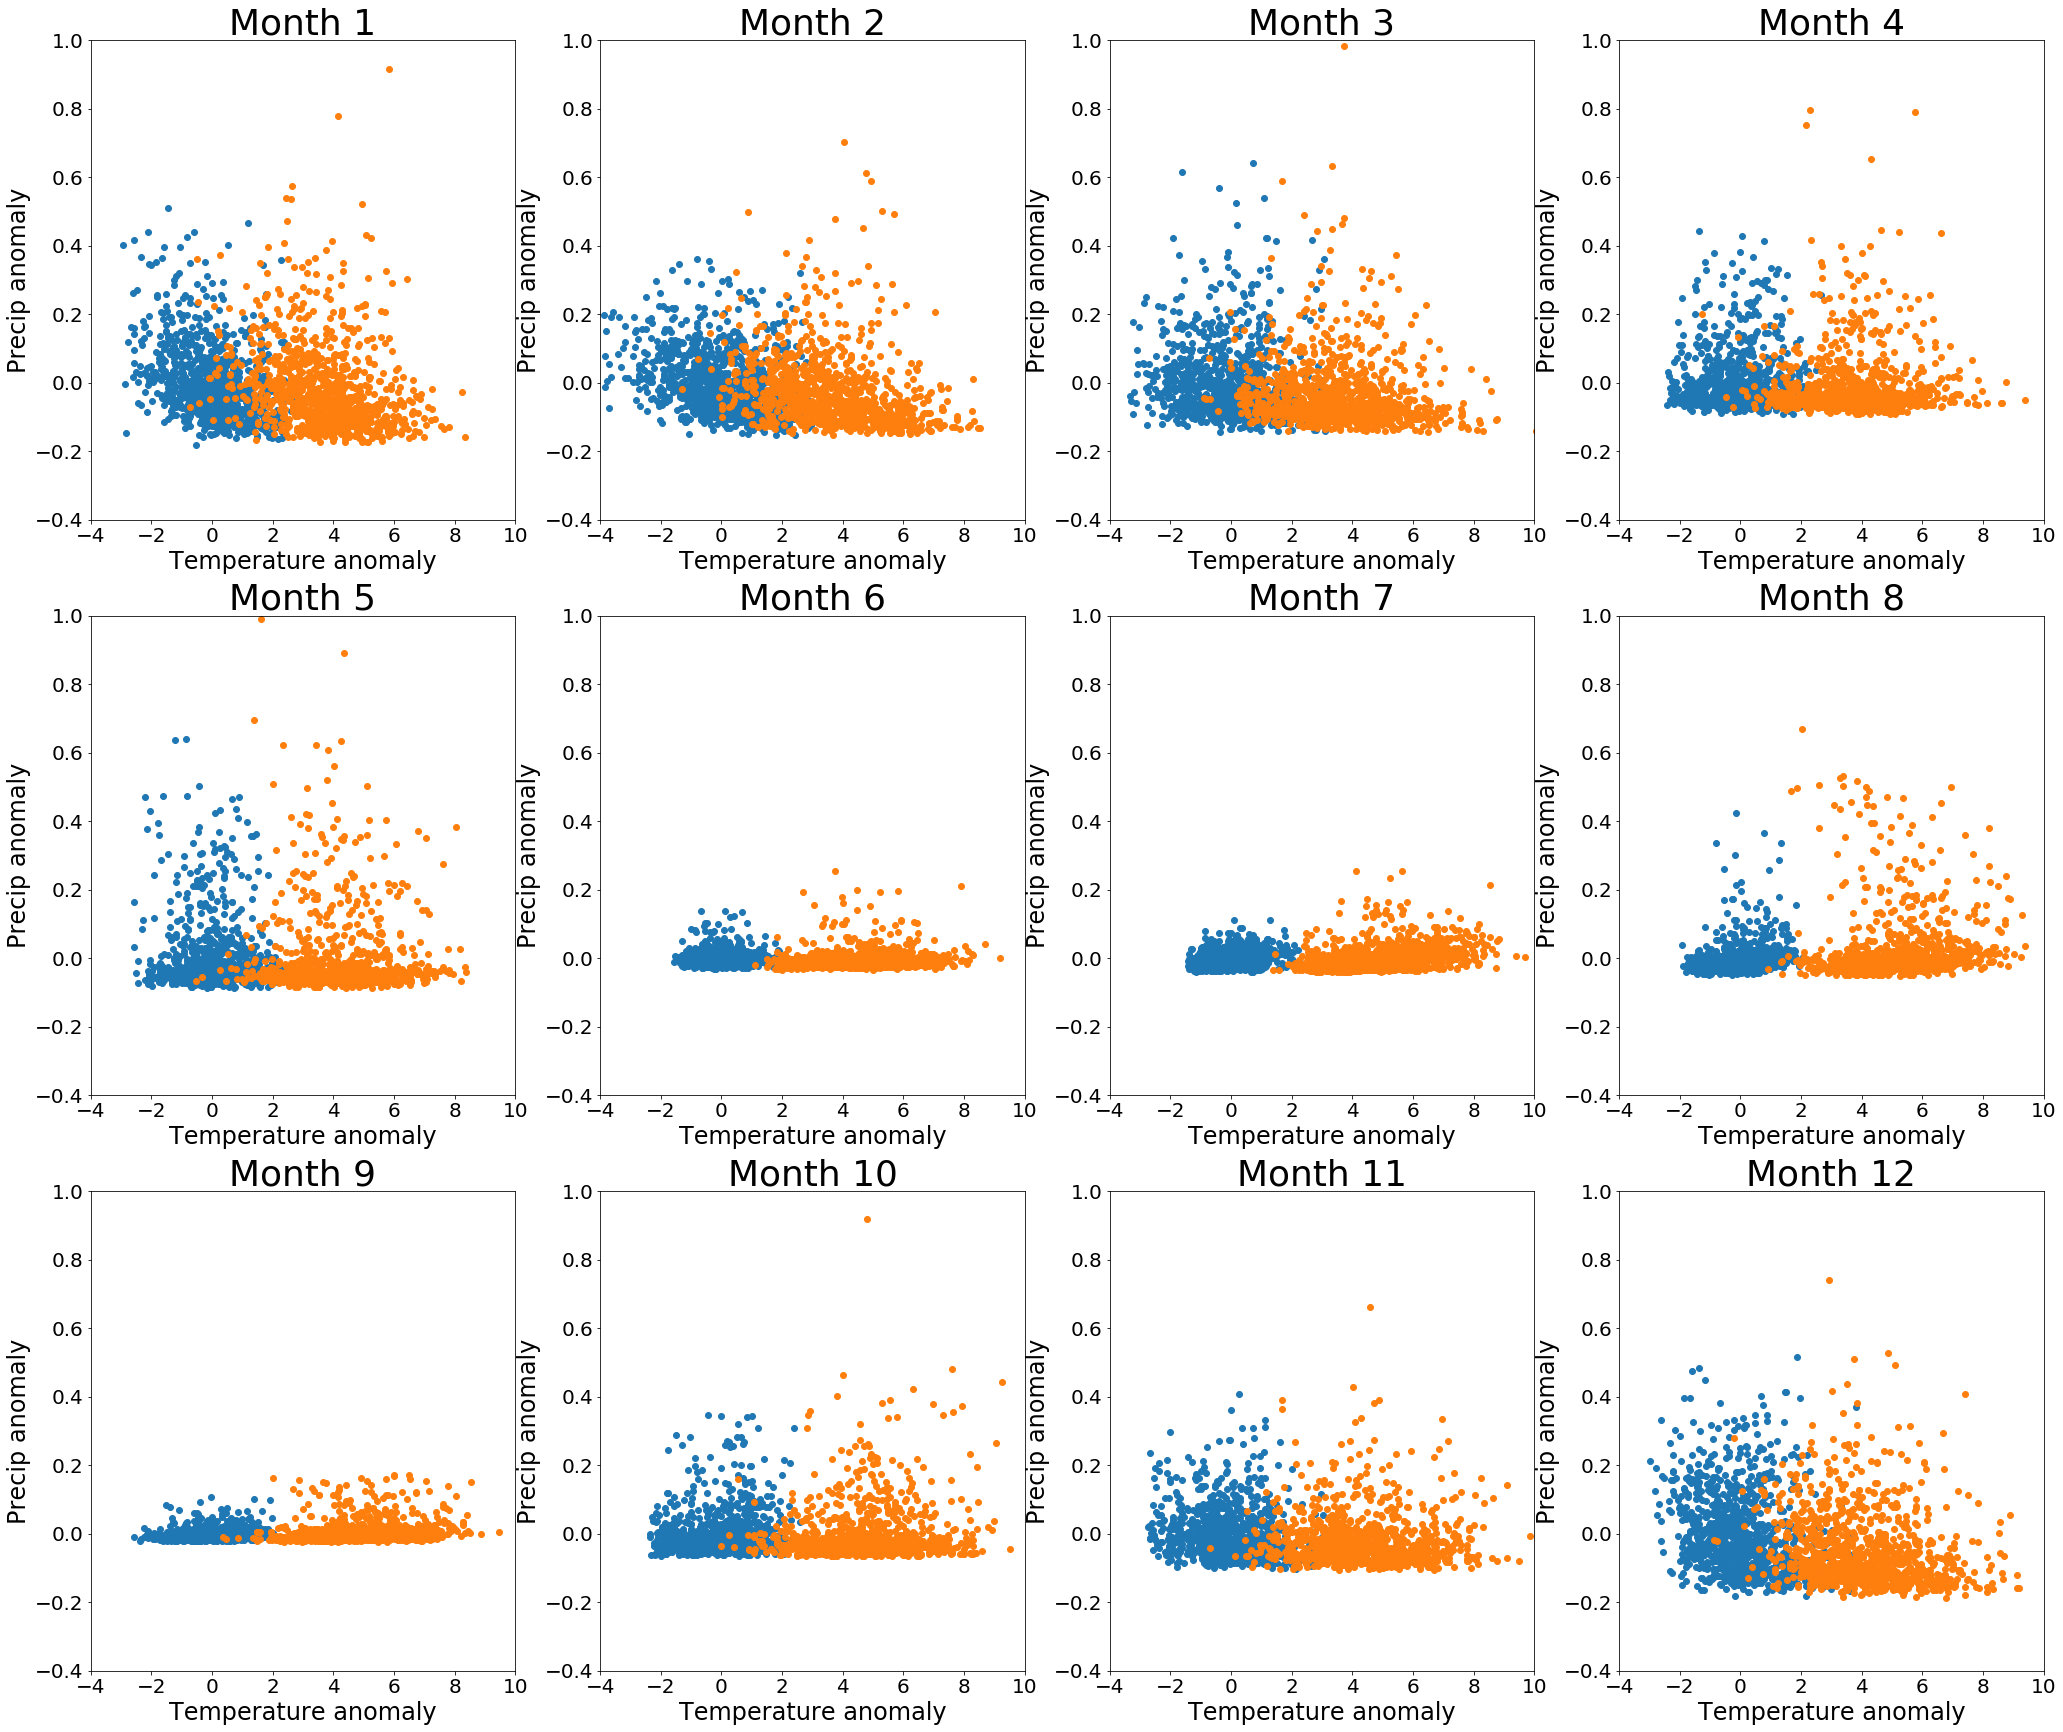

In [260]:
# gather temp/precip anomaly for each month

import matplotlib.pyplot as plt
%matplotlib inline

[prHistorical, models] = readModelData('data/r1-pr-historical.csv')
[tempHistorical, models] = readModelData('data/r1-temp-historical.csv')
[prRcp85, models] = readModelData('data/r1-pr-rcp85.csv')
[tempRcp85, models] = readModelData('data/r1-temp-rcp85.csv')

# monthly anomaly for each historical month/model in each year
historicalTempAnom = []
historicalPrAnom = []
rcp85TempAnom = []
rcp85PrAnom = []

months = list(range(1, 13))

futurePeriod = [2060, 2090]

# find historical monthly means
for month in months:
    # indices for this month
    indTempHistorical = numpy.where(tempHistorical['Month'] == month)
    indPrHistorical = numpy.where(prHistorical['Month'] == month)
    indTempRcp85 = numpy.where((tempRcp85['Month'] == month) & (tempRcp85['Year'] > futurePeriod[0]) & (tempRcp85['Year'] <= futurePeriod[1]))
    indPrRcp85 = numpy.where((prRcp85['Month'] == month) & (tempRcp85['Year'] > futurePeriod[0]) & (tempRcp85['Year'] <= futurePeriod[1]))
    
    # monthly means for all models in current month
    curHistoricalTempMeans = []
    curHistoricalPrMeans = []
    
    # monthly anomalies in past and future
    curHistoricalPrAnoms = []
    curHistoricalTempAnoms = []
    curRcp85PrAnoms = []
    curRcp85TempAnoms = []
    
    for model in models:
        if model == 'Actual': continue
            
        # calculate the historical monthly mean for this model
        meanTemp = numpy.nanmean(tempHistorical[model][indTempHistorical])
        meanPr = numpy.nanmean(prHistorical[model][indPrHistorical])
        
        # save
        curHistoricalTempMeans.append(meanTemp)
        curHistoricalPrMeans.append(meanPr)
        
        # now calculate monthly anomalies
        curHistoricalTempAnoms.append([x - meanTemp for x in tempHistorical[model][indTempHistorical]])
        curHistoricalPrAnoms.append([x - meanPr for x in prHistorical[model][indPrHistorical]])
        
        # and for the future
        curRcp85TempAnoms.append([x - meanTemp for x in tempRcp85[model][indTempRcp85]])
        curRcp85PrAnoms.append([x - meanPr for x in prRcp85[model][indPrRcp85]])
        
    historicalTempAnom.append(curHistoricalTempAnoms)
    historicalPrAnom.append(curHistoricalPrAnoms)
    rcp85TempAnom.append(curRcp85TempAnoms)
    rcp85PrAnom.append(curRcp85PrAnoms)

historicalTempAnom = numpy.array(historicalTempAnom)
historicalPrAnom = numpy.array(historicalPrAnom)
rcp85TempAnom = numpy.array(rcp85TempAnom)
rcp85PrAnom = numpy.array(rcp85PrAnom)

plt.figure(figsize=(35,30))
for month in list(range(0,12)):
    plt.subplot(3, 4, month+1)
    plt.scatter(historicalTempAnom[month, :, :], historicalPrAnom[month, :, :])
    plt.scatter(rcp85TempAnom[month, :, :], rcp85PrAnom[month, :, :])
    plt.title('Month ' + str(month+1), fontsize = 36)
    plt.xlim([-4, 10])
    plt.ylim([-0.4, 1])
    plt.xlabel('Temperature anomaly', fontsize = 24)
    plt.ylabel('Precip anomaly', fontsize = 24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.savefig('monthly-anomalies.png', dpi=600)
